<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Modelo para Plataforma de Delivery
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> </i> 
</p>  

### Desafio: Desenvolver um Modelo que estime com precisão o tempo total de entrega

> 1. Desenvolver Variáveis Explicativas Úteis em Negócio + Variáveis de Geolocalização + Variáveis de Grafos para Otimização da Rota + Variáveis Temporais

- Criação de Variáveis Conceitualmente boas para o Negócio
- Criação de Variáveis usando Estatística Espacial
- Criação de Variáveis usando Grafos para simulação de Rotas
- Criação de Variávei
- Criação de Variáveis a partir de Métodos Novos que podem trazer ganhos

> 2. Desenvolver um Regressor para inferir o Tempo total de entrega (Order Moment Delivered - Order Moment Created)

- Avaliar quais fatores influenciam no tempo de entrega e identificar gargalos operacionais.
- Melhorar a eficiência logística e definir estratégias para otimizar tempos de entrega.
- Testar Regressão Linear, Regressão Quantílica, Random Forest, LightGBM (MAE, MSE, MSLE, Huber Loss) e Rede Neural

# <font color='red' style='font-size: 40px;'> Library   </font>
<hr style='border: 2px solid red;'>

In [ ]:
## Bibliotecas Gerais 
import sys
sys.executable

## Bibliotecas de Análise de Dados
import pandas as pd 
import geopandas as gpd
import builtins as builtins
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display, Image
from tabulate import tabulate
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# Bibliotecas de Manipulação de Tempo
from datetime import datetime, date

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, kruskal, uniform, chi2_contingency
from statsmodels.stats.weightstats import ztest
from numpy import interp
import random


# Bibliotecas de Pré-Processamento e Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Bibliotecas de Modelos de Machine Learning
import joblib
from joblib import Parallel, delayed
import pickle
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
import shap

# Bibliotecas de Métricas de Machine Learning
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score, log_loss, brier_score_loss, confusion_matrix, silhouette_score

# Parâmetros de Otimização
import random
import warnings
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings
# from pyspark.sql import SparkSession, Row 
# from pyspark.sql.functions import *
# import pyspark.sql.functions as F
 

# # Spark Session
# spark = SparkSession.builder.getOrCreate()

In [5]:
def plota_barras(variaveis, df, titulo, rotation=0, figsize=(8,5), top_n=None):
    if isinstance(variaveis, (list, tuple)):
        if len(variaveis) == 0:
            raise ValueError("lista de variáveis vazia")
        if len(variaveis) > 1:
            for v in variaveis:
                plota_barras(v, df, f"{titulo} — {v}", rotation=rotation, figsize=figsize, top_n=top_n)
            return
        variavel = variaveis[0]
    else:
        variavel = variaveis

    counts = df[variavel].value_counts()
    if top_n is not None:
        counts = counts.head(top_n)

    order = counts.index
    values = counts.values
    total = values.sum()

    ax = sns.barplot(x=order, y=values, color='#1FB3E5')

    ax.set_title(titulo, fontsize=14)
    ax.set_xlabel(variavel, fontsize=12)
    ax.set_ylabel('Quantidade', fontsize=12)

    # Adiciona os percentuais em cima das barras
    for i, v in enumerate(values):
        ax.text(
            i,                     # posição X
            v + (max(values) * 0.01),  # posição Y (1% acima da barra)
            f'{(v/total)*100:.2f}%',  # texto
            ha='center', va='bottom', fontsize=10
        )

    ax.set_ylim(0, max(values) * 1.15)  # mais espaço pro texto
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=10)
    ax.set_yticklabels(['{:,.0f}'.format(y) for y in ax.get_yticks()], fontsize=10)

    plt.tight_layout()
    plt.show()


def plota_boxplot(df, variavel, target):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=target, y=variavel, data=df, palette=['green', 'yellow', 'red'])
    plt.title(f'Boxplot Risco de Fraude para {variavel}', fontsize=12)
    plt.xlabel(target)
    plt.ylabel(variavel)

    # Ajuste da disposição dos gráficos
    plt.tight_layout()
    plt.show()



def plota_grafico_linhas(df, x, y, nao_calcula_media, title):

    if nao_calcula_media:
        # Criando o gráfico de linha
        plt.figure(figsize=(8, 5))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        media = df[y].mean()
        # Criando o gráfico de linha
        plt.figure(figsize=(10, 6))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando linha da média
        plt.axhline(y=media, color='r', linestyle='--', linewidth=1, label=f'Média: {media:.2f}')
        plt.legend()

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.ylim(0, 50)
        plt.tight_layout()
        plt.show()

def plot_fraude(df, group_col, figsize=(18,4), cmap="RdYlGn_r"):
    # Agrupamento e cálculo
    df_group = (
        df.groupby(group_col, as_index=False)
          .agg({'transacao':'count', 'risk_transaction':'sum'})
          .rename(columns={'transacao':'qtd', 'risk_transaction':'fraude'})
    )
    df_group['%fraude'] = df_group['fraude'] / df_group['qtd'] * 100

    # Gráfico
    plt.figure(figsize=figsize)
    sns.barplot(
        data=df_group,
        x=group_col,
        y='%fraude',
        palette=cmap  # Use o nome da paleta diretamente
    )
    plt.title(f'% Fraude por {group_col.capitalize()}', fontsize=16)
    plt.xlabel(group_col.capitalize(), fontsize=12)
    plt.ylabel('% Fraude', fontsize=12)

    # Inserindo rótulos nos valores
    for index, row in df_group.iterrows():
        plt.text(
            index, 
            row['%fraude'] + 0.2, 
            f"{row['%fraude']:.1f}", 
            ha='center', 
            va='bottom', 
            fontsize=10, 
            color='black'
        )

    plt.tight_layout()
    plt.show()
    
    return df_group

# <font color='orange' style='font-size: 40px;'> 1. Leitura do Dataset </font>
<hr style='border: 2px solid orange;'>

https://www.kaggle.com/datasets/nosbielcs/brazilian-delivery-center?resource=download

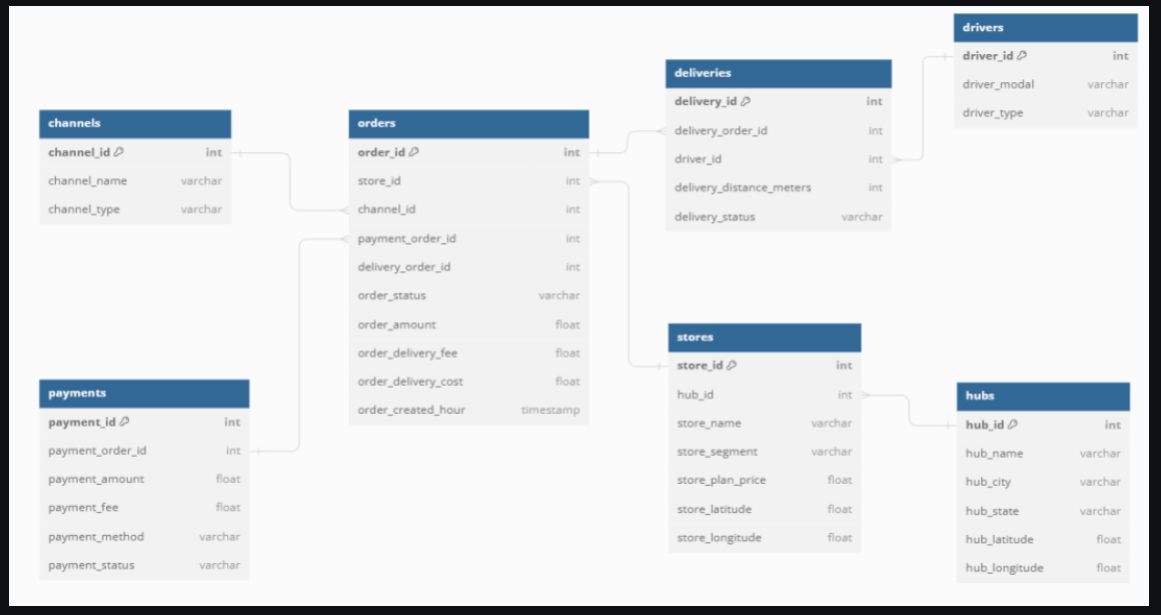

## 1.1.1) Channels

- **Channel ID:** Identificador único do canal de vendas.
- **Channel Name:** Nome do canal de vendas.
- **Channel Type:** Tipo de canal de vendas.

## 1.1.2) Deliveries

- **Delivery Id:** Identificador único da entrega.
- **Delivery Order Id:** Identificador do pedido associado à entrega.
- **Driver Id:** Identificador do entregador responsável pela entrega.
- **Delivery Distance Meters:** Distância total percorrida para a entrega, em metros.
- **Delivery Status:** Status atual da entrega.

## 1.1.3) Drivers

- **Driver Id:** Identificador único do entregador.
- **Driver Modal:** Modalidade de transporte utilizada pelo entregador.
- **Driver Type:** Tipo de entregador.

## 1.1.4) Hubs

- **Hub ID:** Identificador único do hub.
- **Hub Name:** Nome do hub.
- **Hub City:** Cidade onde o hub está localizado.
- **Hub State:** Estado onde o hub está localizado.
- **Hub Latitude:** Latitude da localização do hub.
- **Hub Longitude:** Longitude da localização do hub.

## 1.1.5) Orders

- **Order ID:** Identificador único do pedido.
- **Store ID:** Identificador da loja que recebeu o pedido.
- **Channel ID:** Identificador do canal pelo qual o pedido foi realizado.
- **Payment Order ID:** Identificador do pagamento associado ao pedido.
- **Delivery Order ID:** Identificador da entrega associada ao pedido.
- **Order Status:** Status atual do pedido.
- **Order Amount:** Valor total do pedido.
- **Order Delivery Fee:** Taxa de entrega cobrada ao cliente.
- **Order Delivery Cost:** Custo da entrega para a plataforma ou loja.
- **Order Created Hour:** Hora em que o pedido foi criado.
- **Order Created Minute:** Minuto em que o pedido foi criado.
- **Order Created Day:** Dia em que o pedido foi criado.
- **Order Created Month:** Mês em que o pedido foi criado.
- **Order Created Year:** Ano em que o pedido foi criado.
- **Order Moment Created:** Momento exato em que o pedido foi criado.
- **Order Moment Accepted:** Momento em que o pedido foi aceito pela loja.
- **Order Moment Ready:** Momento em que o pedido ficou pronto para entrega.
- **Order Moment Collected:** Momento em que o pedido foi coletado pelo entregador.
- **Order Moment In Expedition:** Momento em que o pedido entrou em expedição.
- **Order Moment Delivering:** Momento em que o pedido está sendo entregue.
- **Order Moment Delivered:** Momento em que o pedido foi entregue ao cliente.
- **Order Moment Finished:** Momento em que o pedido foi finalizado no sistema.

## 1.1.6) Payments

- **Payment ID:** Identificador único do pagamento.
- **Payment Order ID:** Identificador do pedido associado ao pagamento.
- **Payment Amount:** Valor total pago pelo cliente.
- **Payment Fee:** Taxa de processamento do pagamento.
- **Payment Method:** Método de pagamento utilizado pelo cliente.
- **Payment Status:** Status atual do pagamento.

## 1.1.7) Stores

- **Store ID:** Identificador único da loja.
- **Hub ID:** Identificador do hub ao qual a loja está associada.
- **Store Name:** Nome da loja.
- **Store Segment:** Segmento ou categoria da loja.
- **Store Plan Price:** Preço do plano de assinatura da loja na plataforma.
- **Store Latitude:** Latitude da localização da loja.
- **Store Longitude:** Longitude da localização da loja.


In [2]:
df_channels = pd.read_csv('../Modelo_Delivery/data/channels.csv')
df_deliveries = pd.read_csv('../Modelo_Delivery/data/deliveries.csv')
df_drivers = pd.read_csv('../Modelo_Delivery/data/drivers.csv')
df_hubs = pd.read_csv('../Modelo_Delivery/data/hubs.csv', encoding='latin-1')
df_orders = pd.read_csv('../Modelo_Delivery/data/orders.csv')
df_payments = pd.read_csv('../Modelo_Delivery/data/payments.csv')
df_stores = pd.read_csv('../Modelo_Delivery/data/stores.csv', encoding='latin-1')

# <font color='green' style='font-size: 30px;'> 1.1) Base Channels </font>
<hr style='border: 2px solid green;'>

- **Channel ID:** Identificador único do canal de vendas.
- **Channel Name:** Nome do canal de vendas.
- **Channel Type:** Tipo de canal de vendas.


Dimensão do DataFrame de Canais: (40, 3)


,channel_id,channel_name,channel_type
0,1,OTHER PLACE,OWN CHANNEL
1,2,PHONE PLACE,OWN CHANNEL
2,3,WHATS PLACE,OWN CHANNEL
3,4,FACE PLACE,OWN CHANNEL
4,5,FOOD PLACE,MARKETPLACE


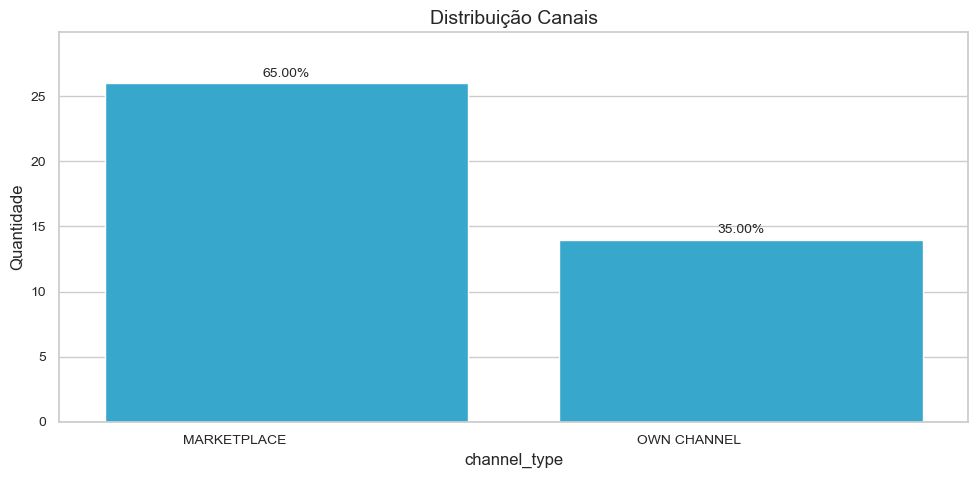

In [7]:
print('Dimensão do DataFrame de Canais:', df_channels.shape)
display(df_channels.head())

plota_barras(['channel_type'], df_channels, 'Distribuição Canais', rotation=0)

# <font color='green' style='font-size: 30px;'> 1.2) Base Deliveries </font>
<hr style='border: 2px solid green;'>

- **Delivery Id:** Identificador único da entrega.
- **Delivery Order Id:** Identificador do pedido associado à entrega.
- **Driver Id:** Identificador do entregador responsável pela entrega.
- **Delivery Distance Meters:** Distância total percorrida para a entrega, em metros.
- **Delivery Status:** Status atual da entrega.


Dimensão do DataFrame de Entregas: (378843, 5)


,delivery_id,delivery_order_id,driver_id,delivery_distance_meters,delivery_status
0,2174658,68413340,8378.00,5199.00,DELIVERED
1,2174660,68414309,2473.00,410.00,DELIVERED
2,2174661,68416230,7615.00,3784.00,DELIVERED
3,2174663,68412721,8378.00,5714.00,DELIVERED
4,2174675,68414018,10463.00,3746.00,DELIVERED


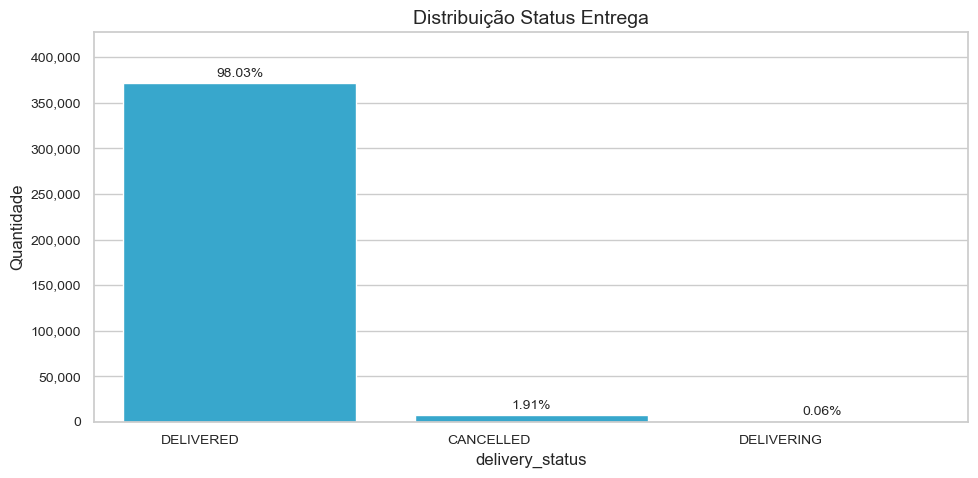

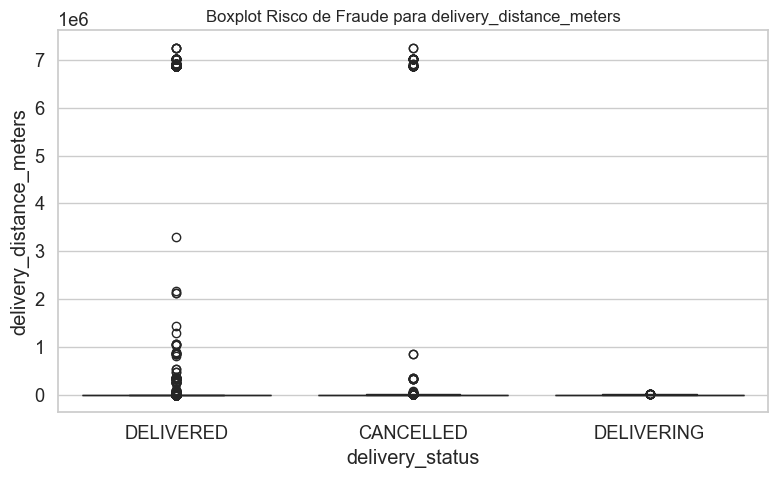

In [12]:
print('Dimensão do DataFrame de Entregas:', df_deliveries.shape)
display(df_deliveries.head())

plota_barras(['delivery_status'], df_deliveries, 'Distribuição Status Entrega', rotation=0)
plota_boxplot(df_deliveries, 'delivery_distance_meters', 'delivery_status')

# <font color='green' style='font-size: 30px;'> 1.3) Base Drivers </font>
<hr style='border: 2px solid green;'>

- **Driver Id:** Identificador único do entregador.
- **Driver Modal:** Modalidade de transporte utilizada pelo entregador.
- **Driver Type:** Tipo de entregador.


Dimensão do DataFrame de Motoristas: (4824, 3)


,driver_id,driver_modal,driver_type
0,133,MOTOBOY,LOGISTIC OPERATOR
1,138,MOTOBOY,FREELANCE
2,140,MOTOBOY,FREELANCE
3,143,BIKER,FREELANCE
4,148,MOTOBOY,FREELANCE


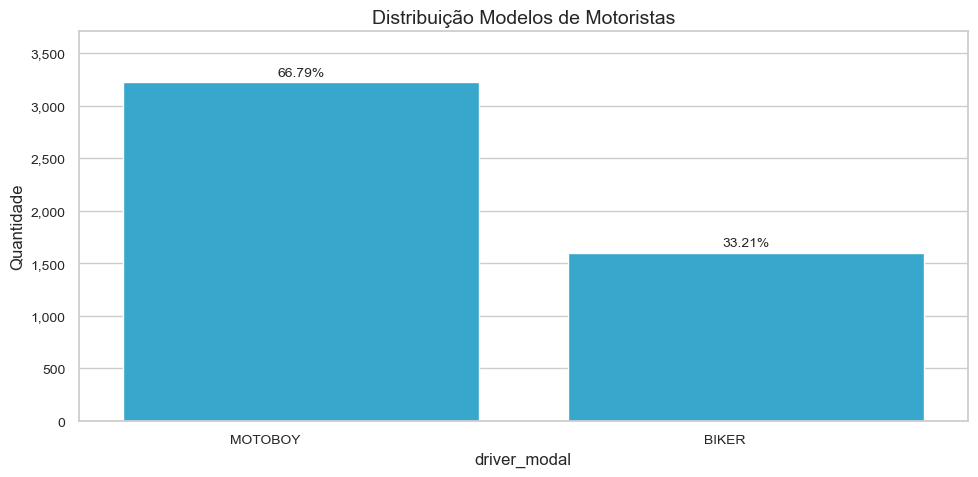

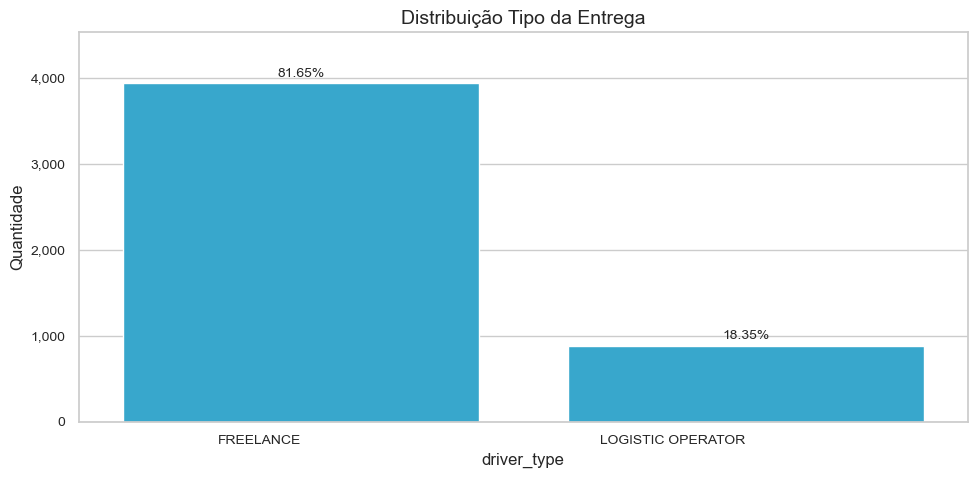

In [11]:
print('Dimensão do DataFrame de Motoristas:', df_drivers.shape)
display(df_drivers.head())

plota_barras(['driver_modal'], df_drivers, 'Distribuição Modelos de Motoristas', rotation=0)
plota_barras(['driver_type'], df_drivers, 'Distribuição Tipo da Entrega', rotation=0)

# <font color='green' style='font-size: 30px;'> 1.4) Base Hubs </font>
<hr style='border: 2px solid green;'>

- **Hub ID:** Identificador único do hub.
- **Hub Name:** Nome do hub.
- **Hub City:** Cidade onde o hub está localizado.
- **Hub State:** Estado onde o hub está localizado.
- **Hub Latitude:** Latitude da localização do hub.
- **Hub Longitude:** Longitude da localização do hub.


Dimensão do DataFrame de Hubs: (5, 7)


,hub_id,hub_name,hub_city,hub_state,hub_latitude,hub_longitude,quantidade
0,2,BLUE SHOPPING,PORTO ALEGRE,RS,-30.05,-51.21,100
1,3,GREEN SHOPPING,PORTO ALEGRE,RS,-30.04,-51.20,250
2,4,RED SHOPPING,PORTO ALEGRE,RS,-30.02,-51.21,500
3,5,FUNK SHOPPING,RIO DE JANEIRO,RJ,-23.00,-43.32,800
4,8,GOLDEN SHOPPING,RIO DE JANEIRO,RJ,-22.92,-43.23,1200


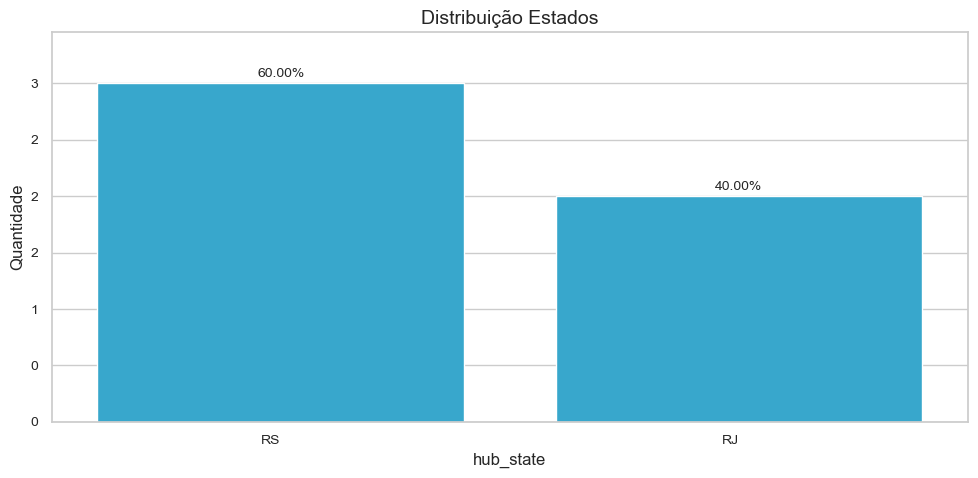

In [20]:
print('Dimensão do DataFrame de Hubs:', df_hubs.shape)
display(df_hubs.head())

plota_barras(['hub_state'], df_hubs, 'Distribuição Estados', rotation=0)

# <font color='green' style='font-size: 30px;'> 1.5) Base Payments </font>
<hr style='border: 2px solid green;'>

- **Payment ID:** Identificador único do pagamento.
- **Payment Order ID:** Identificador do pedido associado ao pagamento.
- **Payment Amount:** Valor total pago pelo cliente.
- **Payment Fee:** Taxa de processamento do pagamento.
- **Payment Method:** Método de pagamento utilizado pelo cliente.
- **Payment Status:** Status atual do pagamento.



In [ ]:
print('Dimensão do DataFrame de Pagamentos:', df_payments.shape)
display(df_payments.head())

# <font color='green' style='font-size: 30px;'> 1.6) Base Stores </font>
<hr style='border: 2px solid green;'>

- **Store ID:** Identificador único da loja.
- **Hub ID:** Identificador do hub ao qual a loja está associada.
- **Store Name:** Nome da loja.
- **Store Segment:** Segmento ou categoria da loja.
- **Store Plan Price:** Preço do plano de assinatura da loja na plataforma.
- **Store Latitude:** Latitude da localização da loja.
- **Store Longitude:** Longitude da localização da loja.


In [ ]:
print('Dimensão do DataFrame de Lojas:', df_stores.shape)
display(df_stores.head())

# <font color='green' style='font-size: 30px;'> 1.7) Base Orders </font>
<hr style='border: 2px solid green;'>

- **Order ID:** Identificador único do pedido.
- **Store ID:** Identificador da loja que recebeu o pedido.
- **Channel ID:** Identificador do canal pelo qual o pedido foi realizado.
- **Payment Order ID:** Identificador do pagamento associado ao pedido.
- **Delivery Order ID:** Identificador da entrega associada ao pedido.
- **Order Status:** Status atual do pedido.
- **Order Amount:** Valor total do pedido.
- **Order Delivery Fee:** Taxa de entrega cobrada ao cliente.
- **Order Delivery Cost:** Custo da entrega para a plataforma ou loja.
- **Order Created Hour:** Hora em que o pedido foi criado.
- **Order Created Minute:** Minuto em que o pedido foi criado.
- **Order Created Day:** Dia em que o pedido foi criado.
- **Order Created Month:** Mês em que o pedido foi criado.
- **Order Created Year:** Ano em que o pedido foi criado.
- **Order Moment Created:** Momento exato em que o pedido foi criado.
- **Order Moment Accepted:** Momento em que o pedido foi aceito pela loja.
- **Order Moment Ready:** Momento em que o pedido ficou pronto para entrega.
- **Order Moment Collected:** Momento em que o pedido foi coletado pelo entregador.
- **Order Moment In Expedition:** Momento em que o pedido entrou em expedição.
- **Order Moment Delivering:** Momento em que o pedido está sendo entregue.
- **Order Moment Delivered:** Momento em que o pedido foi entregue ao cliente.
- **Order Moment Finished:** Momento em que o pedido foi finalizado no sistema.


In [8]:
print('Dimensão do DataFrame de Pedidos:', df_orders.shape)
display(df_orders.head())

Dimensão do DataFrame de Pedidos: (368999, 29)


,order_id,store_id,channel_id,payment_order_id,delivery_order_id,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_day,order_created_month,order_created_year,order_moment_created,order_moment_accepted,order_moment_ready,order_moment_collected,order_moment_in_expedition,order_moment_delivering,order_moment_delivered,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time
0,68405119,3512,5,68405119,68405119,CANCELED,62.70,0.00,NaN,0,1,1,1,2021,1/1/2021 12:01:36 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68405123,3512,5,68405123,68405123,CANCELED,62.70,0.00,NaN,0,4,1,1,2021,1/1/2021 12:04:26 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68405206,3512,5,68405206,68405206,CANCELED,115.50,0.00,NaN,0,13,1,1,2021,1/1/2021 12:13:07 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68405465,3401,5,68405465,68405465,CANCELED,55.90,0.00,NaN,0,19,1,1,2021,1/1/2021 12:19:15 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,68406064,3401,5,68406064,68406064,CANCELED,37.90,0.00,NaN,0,26,1,1,2021,1/1/2021 12:26:25 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# <font color='Orange' style='font-size: 40px;'> 2. Análise da Target </font>
<hr style='border: 2px solid Orange;'>

# <font color='green' style='font-size: 30px;'> 2.1) Target </font>
<hr style='border: 2px solid green;'>

> 1. 

In [11]:
# # Distribuição de Risk Rank
# plota_barras(['risk_rank'], df_metaverse, 'Distribuição Fraudes', rotation=0)


# # Risk Score vs Risk Rank
# plot_histogram_and_boxplot(df_metaverse, 'risk_score', 'risk_rank')

# # Risk Client Vs Safra
# risk_client_por_safra = df_metaverse[["id_enviador", "safra", "risk_client"]].groupby("safra").agg({"risk_client":"sum", "id_enviador":"count"}).reset_index()
# risk_client_por_safra["%risk_client_por_safra"] = round(risk_client_por_safra["risk_client"]/risk_client_por_safra["id_enviador"]*100, 2)
# plota_grafico_linhas(risk_client_por_safra, "safra", "%risk_client_por_safra", False, "Distribuição de Risk Clients (Moderate Risk + High Risk) ao longo das Safras")

# <font color='green' style='font-size: 30px;'> 2.2) Separação de Amostras para Treino, Teste e OOT </font>
<hr style='border: 2px solid green;'>


# <font color='Orange' style='font-size: 40px;'> 3. Análise Exploratória </font>
<hr style='border: 2px solid Orange;'>

# <font color='green' style='font-size: 30px;'> 3.1) Tipo de Dados </font>
<hr style='border: 2px solid green;'>

In [12]:
# df_metaverse.dtypes

# <font color='green' style='font-size: 30px;'> 3.2) Nulos </font>
<hr style='border: 2px solid green;'>

In [13]:
# df_nulls = (
#     pd.DataFrame(
#         df_metaverse
#         # .drop(["msno", "safra", "churn"] + variaveis_desconsideradas, axis = 1)
#         .isnull().sum()
#       )
#       .reset_index()
#       .rename({0:'nulls_amnt'}, axis = 1)
# )
# df_nulls['nulls_rate'] = round((df_nulls['nulls_amnt']/df_metaverse.shape[0])*100, 2)

# print(f'Existem {len(df_nulls)} variáveis no Dataset')
# df_not_nulls_nulls = df_nulls.loc[df_nulls['nulls_rate'] == 0]
# columns_not_nulls = list(df_not_nulls_nulls['index'])
# print(f'Existem {len(columns_not_nulls)} variáveis sem registros nulos no Dataset')

# plota_grafico_linhas(df_nulls, "index", "nulls_rate", True, "Distribuição da Taxa de Instâncias Nulas para cada Variável")

# <font color='green' style='font-size: 30px;'> 3.3) Variáveis </font>
<hr style='border: 2px solid green;'>

In [14]:
# # Função para formatar os números
# def format_number(n):
#     if n >= 1_000_000:
#         return f'{n / 1_000_000:.1f}MM'  # Para milhões (ex: 50.0MM)
#     elif n >= 1_000:
#         return f'{n / 1_000:.1f}K'  # Para milhares (ex: 50.0K)
#     else:
#         return str(n)  # Para valores menores que 1.000

# # Carregando o mapa do Brasil com Geopandas
# url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
# gdf = gpd.read_file(url)

# # Unindo os dados de casos com os dados de geolocalização dos estados
# gdf = gdf.set_index('sigla').join(df_cases_states_cross_section.set_index('state'))

# # Plotando o mapa
# fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# # Plotando o mapa com cores que variam de verde (menos casos) a vermelho (mais casos)
# gdf.plot(column='cases', ax=ax, legend=True,
#          legend_kwds={'label': "Total de Casos por Estado",
#                       'orientation': "horizontal"},
#          cmap='RdYlGn_r', edgecolor='black')

# # Adicionando o número de casos em cada estado
# for idx, row in gdf.iterrows():
#     # Obtendo o centroide de cada estado
#     x, y = row.geometry.centroid.x, row.geometry.centroid.y
    
#     # Formatando o número de casos
#     formatted_cases = format_number(row['cases'])
    
#     # Adicionando o número de casos no centroide do estado
#     ax.annotate(f'{formatted_cases}', xy=(x, y), xytext=(3, 3), textcoords="offset points",
#                 fontsize=10, color='black', ha='center')

#     # Adicionando a sigla do estado no centroide
#     ax.annotate(f'{row.name}', xy=(x, y), xytext=(0, 10), textcoords="offset points",
#                 fontsize=12, color='black', ha='center')

# # Adicionando o título
# ax.set_title("Distribuição de Casos por Estado - Brasil", fontsize=16)

# # Exibindo o mapa
# plt.tight_layout()
# plt.show()

# # Carregando o mapa do Brasil com Geopandas
# url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
# gdf = gpd.read_file(url)

# # Unindo os dados de taxas com os dados de geolocalização dos estados
# gdf = gdf.set_index('sigla').join(df_cases_states_cross_section.set_index('state'))

# # Plotando o mapa
# fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# # Plotando o mapa com cores que variam de verde (menor taxa) a vermelho (maior taxa)
# gdf.plot(column='tax_deaths_per_cases', ax=ax, legend=True,
#          legend_kwds={'label': "Taxa de Mortes por Casos (%)",
#                       'orientation': "horizontal"},
#          cmap='RdYlGn_r', edgecolor='black')

# # Adicionando a taxa de mortes por caso em cada estado
# for idx, row in gdf.iterrows():
#     # Obtendo o centroide de cada estado
#     x, y = row.geometry.centroid.x, row.geometry.centroid.y
    
#     # Formatando a taxa de mortes
#     formatted_rate = f'{row["tax_deaths_per_cases"]:.2f}%'
    
#     # Adicionando a taxa de mortes no centroide do estado
#     ax.annotate(f'{formatted_rate}', xy=(x, y), xytext=(3, 3), textcoords="offset points",
#                 fontsize=10, color='black', ha='center')

#     # Adicionando a sigla do estado no centroide
#     ax.annotate(f'{row.name}', xy=(x, y), xytext=(0, 10), textcoords="offset points",
#                 fontsize=12, color='black', ha='center')

# # Adicionando o título
# ax.set_title("Taxa de Mortes por Casos - Brasil", fontsize=16)

# # Exibindo o mapa
# plt.tight_layout()
# plt.show()